In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

from transform_filter_data import transform_filter_data

2023-10-26 21:53:28.760044: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 21:53:28.760087: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 21:53:28.760126: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 21:53:28.769400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 21:53:30.032148: W tensorflow/compiler/

In [2]:
history_lens = [
    pd.Timedelta('365 days'),
    pd.Timedelta('270 days'),
    pd.Timedelta('180 days'),
    pd.Timedelta('90 days'),
]

span_thresholds = [
    pd.Timedelta('90 days'),
    pd.Timedelta('60 days'),
    pd.Timedelta('40 days'),
    pd.Timedelta('20 days'),
]

idx = 0 # At first, let's try for 365 days access pattern length

history_len = history_lens[idx]
span_threshold = span_thresholds[idx]

accesses_threshold = 30
source_csv = (
    '/home/mshubin/Desktop/datasets-popularity-task-data/' +
    'datasets_popularity_DAOD_mixed_' + 
    'higgd-topq-susy-phys_mc16_13TeV_202308141254.csv'
)
finish_date_train_test = pd.Timestamp('2023-03-21')
finish_date_validate = pd.Timestamp('2023-04-06')
horizon = pd.Timedelta('7 days')
test_frac = 0.05

In [3]:
print('started:', time.strftime('%Y-%m-%d %H:%M:%S'))
t1 = time.clock_gettime_ns(time.CLOCK_REALTIME)


objs_df = transform_filter_data(
    source_csv = source_csv,
    finish_date = finish_date_train_test,
    horizon_date = finish_date_train_test + horizon,
    span_threshold = span_threshold,
    history_len = history_len,
    accesses_threshold = accesses_threshold,
    merge_tids=True
)

t2 = time.clock_gettime_ns(time.CLOCK_REALTIME)

print('finished:', time.strftime('%Y-%m-%d %H:%M:%S'))
print('Elapsed time (seconds):', (t2 - t1) / 1_000_000_000)

started: 2023-10-26 21:53:32
merging datasets with different tids


100%|████████████████████████████| 5725288/5725288 [00:04<00:00, 1337664.75it/s]


filling 'y' and 'n_sub_datasets' columns


100%|█████████████████████████████████| 255430/255430 [00:48<00:00, 5241.01it/s]


after filtering by access number: 1746 / 31339
filtering by history presence


100%|████████████████████████████████████| 31339/31339 [00:45<00:00, 686.04it/s]


after filtering: 1704 / 29457
transforming date arrays to timeseries


100%|████████████████████████████████████| 29457/29457 [01:02<00:00, 469.73it/s]


finished: 2023-10-26 21:56:55
Elapsed time (seconds): 203.104500441


### Creating balanced train and balanced test sets (50 / 50 % for '0' and '1' classes)

In [4]:
objs_1 = objs_df[objs_df['y'] > 0]
objs_1 = objs_1.sample(frac=1, random_state=41) # SHUFFLE
n1 = len(objs_1)
n1_test = int(n1 * test_frac)
n1_train = n1 - n1_test


train_df = pd.DataFrame(objs_1.iloc[:-n1_test])
train_df = pd.concat(
    [
        train_df,
        objs_df[objs_df['y'] == 0].sample(n1_train, random_state=42)
    ]
)

test_df = pd.DataFrame(objs_1.iloc[-n1_test:])
test_df = pd.concat(
    [
        test_df,
        objs_df[objs_df['y'] == 0].sample(n1_test, random_state=43)
    ]
)

train_df = train_df.sample(frac=1, random_state=44) # SHUFFLE
test_df = test_df.sample(frac=1, random_state=45) # SHUFFLE

In [5]:
Xtrain = np.stack(train_df['history_ts'].to_numpy())
Ytrain = (train_df['y'].to_numpy() > 0).astype('int')
Xtest = np.stack(test_df['history_ts'].to_numpy())
Ytest = (test_df['y'].to_numpy() > 0).astype('int')

In [6]:
T = Xtrain.shape[1] # num of time steps in time series
D = 1               # dimenstion
K = 2               # num of classes

In [7]:
Xtrain = Xtrain.reshape((Xtrain.shape[0], Xtrain.shape[1], D))
Xtest = Xtest.reshape((Xtest.shape[0], Xtest.shape[1], D))

In [8]:
np.random.seed(123)
random.seed(123)
tf.random.set_seed(1234)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(T,D)))
model.add(tf.keras.layers.LSTM(24, return_sequences=True))
model.add(tf.keras.layers.LSTM(24, return_sequences=True))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(K))

model.summary()

2023-10-26 21:56:55.828341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2138 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:03:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 365, 24)           2496      
                                                                 
 lstm_1 (LSTM)               (None, 365, 24)           4704      
                                                                 
 global_max_pooling1d (Glob  (None, 24)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 2)                 50        
                                                                 
Total params: 7250 (28.32 KB)
Trainable params: 7250 (28.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)
# The from_logits=True attribute inform the loss function that the output values
# generated by the model are not normalized, a.k.a. logits. In other words, the
# softmax function has not been applied on them to produce a probability
# distribution. The softmax function would be automatically applied on the output
# values by the loss function. Therefore, this does not make a difference with the
# scenario when you use from_logits=False (default) and a softmax activation
# function on last layer; however, in some cases, this might help with numerical
# stability during training of the model.

In [10]:
check_point = tf.keras.callbacks.ModelCheckpoint(
    'model_states/lstm_best_model.h5', monitor='val_loss', save_best_only=True
)

In [11]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=50,
    callbacks=[check_point],
    validation_data=(Xtest, Ytest)
)

Epoch 1/50


2023-10-26 21:57:01.400351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904
2023-10-26 21:57:01.649042: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef9cc01c740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-26 21:57:01.649078: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-10-26 21:57:01.660938: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-26 21:57:01.810742: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


102/102 [==============================] - 10s 47ms/step - loss: 0.6418 - accuracy: 0.6130 - val_loss: 0.5823 - val_accuracy: 0.6706
Epoch 2/50
  5/102 [>.............................] - ETA: 3s - loss: 0.5617 - accuracy: 0.7125

/home/mshubin/soft/app/linux/python3-venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


102/102 [==============================] - 4s 35ms/step - loss: 0.5204 - accuracy: 0.7421 - val_loss: 0.5028 - val_accuracy: 0.7824
Epoch 3/50
102/102 [==============================] - 4s 36ms/step - loss: 0.3906 - accuracy: 0.8425 - val_loss: 0.4199 - val_accuracy: 0.8176
Epoch 4/50
102/102 [==============================] - 4s 37ms/step - loss: 0.3069 - accuracy: 0.8731 - val_loss: 0.3233 - val_accuracy: 0.8647
Epoch 5/50
102/102 [==============================] - 4s 36ms/step - loss: 0.3271 - accuracy: 0.8684 - val_loss: 0.5582 - val_accuracy: 0.7294
Epoch 6/50
102/102 [==============================] - 4s 38ms/step - loss: 0.5504 - accuracy: 0.7230 - val_loss: 0.6979 - val_accuracy: 0.5059
Epoch 7/50
102/102 [==============================] - 4s 39ms/step - loss: 0.6718 - accuracy: 0.5389 - val_loss: 0.6426 - val_accuracy: 0.6294
Epoch 8/50
102/102 [==============================] - 4s 38ms/step - loss: 0.6326 - accuracy: 0.6208 - val_loss: 0.5972 - val_accuracy: 0.6765
Epoch 9/50

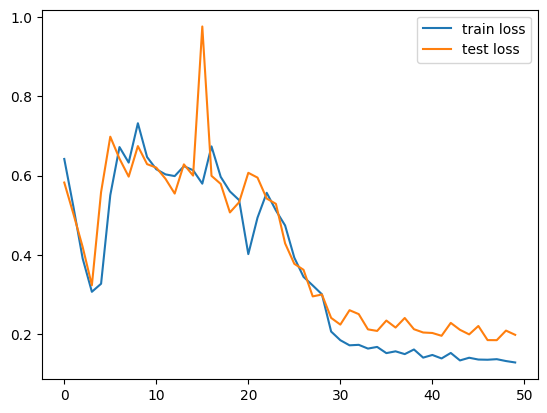

In [12]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

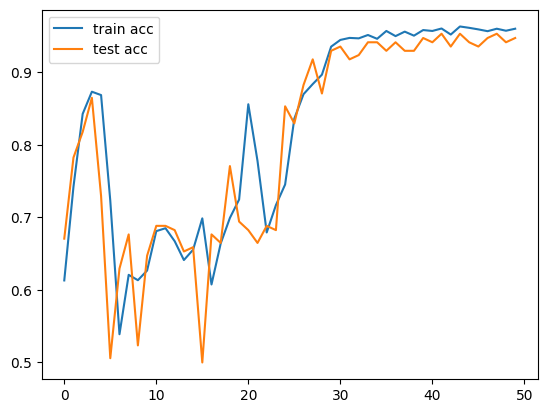

In [13]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [14]:
best_model = tf.keras.models.load_model('model_states/lstm_best_model.h5')

In [15]:
Ptest = best_model.predict(Xtest)

6/6 [==============================] - 1s 17ms/step


In [16]:
Ptest

array([[ 2.52704692e+00, -1.42154384e+00],
       [-1.34775877e+00,  2.45586276e+00],
       [-9.67911959e-01,  2.41607261e+00],
       [ 2.75930786e+00, -1.72419190e+00],
       [-2.00339627e+00,  2.89925408e+00],
       [-1.40716219e+00,  2.59000802e+00],
       [-2.05309486e+00,  2.30537868e+00],
       [ 2.97733235e+00, -1.81526542e+00],
       [ 3.49289107e+00, -2.26066089e+00],
       [ 3.05728817e+00, -1.97115493e+00],
       [ 3.13655305e+00, -1.93660927e+00],
       [ 3.14848351e+00, -2.12051749e+00],
       [-1.65824860e-01,  9.90785778e-01],
       [-1.67398250e+00,  2.79256153e+00],
       [ 2.26203012e+00, -1.16226125e+00],
       [ 2.89644504e+00, -1.85730815e+00],
       [ 8.63235116e-01, -8.35780799e-02],
       [ 3.02395797e+00, -1.96029472e+00],
       [-1.19035673e+00,  2.43778181e+00],
       [ 3.09979987e+00, -2.05587459e+00],
       [-1.20225084e+00,  2.46152520e+00],
       [-3.37019891e-01,  1.07702470e+00],
       [ 1.20690215e+00, -3.58971059e-01],
       [-9.

In [17]:
Ypred = np.argmax(Ptest, axis=1)
Ypred

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0])

In [18]:
np.mean(Ypred == Ytest)

0.9529411764705882

In [19]:
result = {}

result['test_accuracy'] = accuracy_score(Ytest, Ypred)
result['test_confusion_matrix'] = confusion_matrix(Ytest, Ypred)
result['test_classification_report'] = classification_report(Ytest, Ypred)

print(f"Accuracy: {result['test_accuracy']}")
print('Confusion Matrix')
print(result['test_confusion_matrix'])
print(result['test_classification_report'])

Accuracy: 0.9529411764705882
Confusion Matrix
[[78  7]
 [ 1 84]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95        85
           1       0.92      0.99      0.95        85

    accuracy                           0.95       170
   macro avg       0.96      0.95      0.95       170
weighted avg       0.96      0.95      0.95       170



## Trying to test on another datetime cutoff

In [20]:
print('started:', time.strftime('%Y-%m-%d %H:%M:%S'))
t1 = time.clock_gettime_ns(time.CLOCK_REALTIME)


objs_df_test = transform_filter_data(
    source_csv = source_csv,
    finish_date = finish_date_validate,
    horizon_date = finish_date_validate + horizon,
    span_threshold = span_threshold,
    history_len = history_len,
    accesses_threshold = accesses_threshold,
    merge_tids=True
)

t2 = time.clock_gettime_ns(time.CLOCK_REALTIME)

print('finished:', time.strftime('%Y-%m-%d %H:%M:%S'))
print('Elapsed time (seconds):', (t2 - t1) / 1_000_000_000)

started: 2023-10-26 22:00:18
merging datasets with different tids


100%|████████████████████████████| 5725288/5725288 [00:04<00:00, 1331608.46it/s]


filling 'y' and 'n_sub_datasets' columns


100%|█████████████████████████████████| 256798/256798 [00:45<00:00, 5640.73it/s]


after filtering by access number: 1027 / 31471
filtering by history presence


100%|████████████████████████████████████| 31471/31471 [00:43<00:00, 716.31it/s]


after filtering: 999 / 29647
transforming date arrays to timeseries


100%|████████████████████████████████████| 29647/29647 [00:59<00:00, 497.81it/s]


finished: 2023-10-26 22:03:32
Elapsed time (seconds): 194.218889168


In [21]:
objs_test_1 = objs_df_test[objs_df_test['y'] > 0]

test2_df = pd.DataFrame(objs_test_1)
test2_df = pd.concat(
    [
        test2_df,
        objs_df_test[objs_df_test['y'] == 0].sample(len(test2_df),
                                                    random_state=46)
    ]
)

In [22]:
Xtest2 = np.stack(test2_df['history_ts'].to_numpy())
Ytest2 = (test2_df['y'].to_numpy() > 0).astype('int')
Xtest2 = Xtest2.reshape((Xtest2.shape[0], Xtest2.shape[1], D))

In [23]:
Ptest2 = best_model.predict(Xtest2)

63/63 [==============================] - 1s 15ms/step


In [24]:
Ypred2 = np.argmax(Ptest2, axis=1)

result2 = {}

result2['test_accuracy'] = accuracy_score(Ytest2, Ypred2)
result2['test_confusion_matrix'] = confusion_matrix(Ytest2, Ypred2)
result2['test_classification_report'] = classification_report(Ytest2, Ypred2)

print(f"Accuracy: {result2['test_accuracy']}")
print('Confusion Matrix')
print(result2['test_confusion_matrix'])
print(result2['test_classification_report'])

Accuracy: 0.9104104104104104
Confusion Matrix
[[941  58]
 [121 878]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       999
           1       0.94      0.88      0.91       999

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



### Не дурно ☝☝☝.

### А что, если теперь взять и оценить модель на несбалансированном наборе (где много ответов 0)?

In [25]:
test3_df = objs_df_test.sample(len(test2_df), random_state=47)
Xtest3 = np.stack(test3_df['history_ts'].to_numpy())
Ytest3 = (test3_df['y'].to_numpy() > 0).astype('int')
Xtest3 = Xtest3.reshape((Xtest3.shape[0], Xtest3.shape[1], D))
Ptest3 = best_model.predict(Xtest3)

Ypred3 = np.argmax(Ptest3, axis=1)

result3 = {}

result3['test_accuracy'] = accuracy_score(Ytest3, Ypred3)
result3['test_confusion_matrix'] = confusion_matrix(Ytest3, Ypred3)
result3['test_classification_report'] = classification_report(Ytest3, Ypred3)

print(f"Accuracy: {result3['test_accuracy']}")
print('Confusion Matrix')
print(result3['test_confusion_matrix'])
print(result3['test_classification_report'])

63/63 [==============================] - 1s 16ms/step
Accuracy: 0.93993993993994
Confusion Matrix
[[1820  117]
 [   3   58]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1937
           1       0.33      0.95      0.49        61

    accuracy                           0.94      1998
   macro avg       0.66      0.95      0.73      1998
weighted avg       0.98      0.94      0.95      1998



Многовато ложноположительных ответов в конфьюжн матрице (117).
Т.е. наш предсказатель будет предлагать создавать много лишних реплик.
Зато любой популярный датасет с высокой вероятностью не останется без реплики...